In [22]:
from dataset import Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

#### DEFINE PARAMETERS

In [2]:
TICKERS = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT',
           'BNBUSDT', 'ADAUSDT', 'XRPUSDT', 'DOTUSDT']
DAYS = 30
TIMEFRAME = '5m'
SPLIT = 0.8

#### Download Dataset

In [3]:
dataset = Dataset().get_datas(days=DAYS, tickers=TICKERS, ts=TIMEFRAME)

#### Check Dataset

In [4]:
data = dataset.copy()
data['dayOfYear'] = data.index.dayofyear
data.groupby('symbol')\
    .apply(lambda x: x.tail(2))

open        high         low       close  \
symbol  time                                                                  
ADAUSDT 2022-04-21 08:35:00      0.9510      0.9510      0.9490      0.9490   
        2022-04-21 08:40:00      0.9490      0.9500      0.9470      0.9480   
BNBUSDT 2022-04-21 08:35:00    420.7000    421.1000    420.1000    420.8000   
        2022-04-21 08:40:00    420.9000    421.0000    420.4000    420.4000   
BTCUSDT 2022-04-21 08:35:00  41882.2500  41938.4600  41830.9400  41909.7200   
        2022-04-21 08:40:00  41909.7300  41930.0000  41890.0000  41929.9900   
DOTUSDT 2022-04-21 08:35:00     19.2600     19.2900     19.2300     19.2700   
        2022-04-21 08:40:00     19.2800     19.2800     19.2300     19.2400   
ETHUSDT 2022-04-21 08:35:00   3099.3000   3103.5600   3094.8600   3100.5400   
        2022-04-21 08:40:00   3100.5500   3101.6900   3097.8400   3098.7400   
LTCUSDT 2022-04-21 08:35:00    111.0000    111.2000    110.9000    111.0000   
        2022-04-21 08:40:00    111.0000    111.2000    111.0000    111.1000   
XRPUSDT 2022-04-21 08:35:00      0.7495      0.7496      0.7483      0.7490   
        2022-04-21 08:40:00      0.7490      0.7493      0.7482      0.7485   

                                   volume   symbol  dayOfYear  
symbol  time                                                   
ADAUSDT 2022-04-21 08:35:00  123276.00000  ADAUSDT        111  
        2022-04-21 08:40:00  269408.70000  ADAUSDT        111  
BNBUSDT 2022-04-21 08:35:00    2429.39500  BNBUSDT        111  
        2022-04-21 08:40:00    1122.03600  BNBUSDT        111  
BTCUSDT 2022-04-21 08:35:00     228.02268  BTCUSDT        111  
        2022-04-21 08:40:00      83.44531  BTCUSDT        111  
DOTUSDT 2022-04-21 08:35:00    5515.73000  DOTUSDT        111  
        2022-04-21 08:40:00    8498.52000  DOTUSDT        111  
ETHUSDT 2022-04-21 08:35:00    1357.04630  ETHUSDT        111  
        2022-04-21 08:40:00     519.33820  ETHUSDT        111  
LTCUSDT 2022-04-21 08:35:00     573.77400  LTCUSDT        111  
        2022-04-21 08:40:00     656.32100  LTCUSDT        111  
XRPUSDT 2022-04-21 08:35:00  611347.00000  XRPUSDT        111  
        2022-04-21 08:40:00  577340.00000  XRPUSDT        111

#### Processing Dataset

In [5]:
df = data.groupby('symbol')\
    .apply(lambda x: x)\
    .assign(target=lambda x: x['close'].shift(-1))\
    .groupby('dayOfYear')\
    .apply(lambda x: x)\
    .dropna()
print(df.head(len(TICKERS)))

                           open        high         low       close  \
time                                                                  
2022-03-22 00:05:00      0.9170      0.9220      0.9120      0.9130   
2022-03-22 00:05:00    396.0000    396.3000    395.4000    395.5000   
2022-03-22 00:05:00  41002.2600  41025.0100  40959.3700  40964.5600   
2022-03-22 00:05:00     18.7500     18.7600     18.7000     18.7000   
2022-03-22 00:05:00   2890.0300   2895.0700   2886.4300   2889.3400   
2022-03-22 00:05:00    116.1000    116.2000    115.8000    115.9000   
2022-03-22 00:05:00      0.8372      0.8436      0.8366      0.8391   

                           volume   symbol  dayOfYear      target  
time                                                               
2022-03-22 00:05:00  1.863204e+06  ADAUSDT         81      0.9150  
2022-03-22 00:05:00  1.690082e+03  BNBUSDT         81    396.1000  
2022-03-22 00:05:00  2.307740e+02  BTCUSDT         81  41003.4400  
2022-03-22 00:05:00 

### Split Dataset on train and test data

In [6]:

unique_days = df.dayOfYear.unique()
train_days = unique_days[:int(len(unique_days) * SPLIT)]
test_days = unique_days[int(len(unique_days) * SPLIT):]
train = df[df.dayOfYear.isin(train_days)]
test = df[df.dayOfYear.isin(test_days)]

In [7]:
X_train = train.drop(['target', 'dayOfYear', 'symbol'], axis=1)
y_train = train['target']
X_test = test.drop(['target', 'dayOfYear', 'symbol'], axis=1)
y_test = test['target']
print('train days:', X_train.values.shape)
print('test days:', X_test.values.shape)

train days: (48377, 5)
test days: (12830, 5)


#### Data Transformation
*Rescaling (MinMaxScaler)* - Converts data to a single scale that is between 0 and 1. Increases computational speed for algorithms.

*Standardization (StandardScaler)* - Transforms the data so that it is normally distributed with a mean of 0. Often helps to increase the accuracy of algorithms.

*Normalization (Normalizer)* - Normalization refers to rescaling each observation (row) to have a length of one (called a unit norm or a vector). Thi*s preprocessing method can be useful for sparse datasets of attributes of varying scales when using algorithms that weight input values.

In [12]:
scaler = StandardScaler().fit(X_train)
standardised_X_train = pd.DataFrame(scaler.fit_transform(X_train))
standardised_X_test = pd.DataFrame(scaler.transform(X_test))


#### Create Base model

In [20]:
model = LinearRegression()
model.fit(standardised_X_train, y_train)
y_pred = model.predict(standardised_X_train)
rmse_lin = np.sqrt(mean_squared_error(y_train, y_pred))
r2_lin = r2_score(y_train, y_pred)
print("RMSE for Linear Regression:", rmse_lin)

RMSE for Linear Regression: 25.630953555225414


### Improve model
The primary assumption of Polynomial Regression is that there might exist a non-linear relationship between the features (independent variables) and the target (dependent variable). It is also used when the linear model is unable to capture the trend in the data and gives a poor R² score.

In [21]:
polynomial_features = PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X_train)
model = LinearRegression()
model.fit(x_poly, y_train)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y_train, y_poly_pred))
r2 = r2_score(y_train, y_poly_pred)
print("RMSE for Polynomial Regression:", rmse)


RMSE for Polynomial Regression: 25.552984049058818


#### Tuning model

Text(0.5, 0.98, 'Algorithm Comparison')

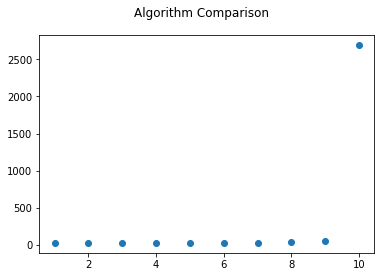

In [29]:
params = np.arange(1, 11)
results = []
names = []
for deg in params:
    polynomial_features = PolynomialFeatures(degree=deg)
    x_poly = polynomial_features.fit_transform(standardised_X_train)
    model = LinearRegression()
    model.fit(x_poly, y_train)
    y_poly_pred = model.predict(x_poly)
    rmse = np.sqrt(mean_squared_error(y_train, y_poly_pred))
    r2 = r2_score(y_train, y_poly_pred)
    results.append(rmse)
    names.append(deg)
plt.plot(names, results, 'o')
plt.suptitle('Algorithm Comparison')


In [37]:
print('Best for train', names[[idx for idx, val in enumerate(results) if val == min(results)][0]])


Best for train 4


#### Check parameters on test data

Text(0.5, 0.98, 'Algorithm Comparison')

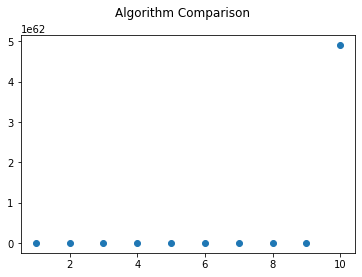

In [38]:
params = np.arange(1, 11)
results_test = []
names_test = []
for deg in params:
    polynomial_features = PolynomialFeatures(degree=deg)
    x_poly = polynomial_features.fit_transform(standardised_X_train)
    model = LinearRegression()
    model.fit(x_poly, y_train)
    x_poly_test = polynomial_features.fit_transform(X_test)
    y_poly_pred_test = model.predict(x_poly_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_poly_pred_test))
    r2 = r2_score(y_test, y_poly_pred_test)
    results_test.append(rmse)
    names_test.append(deg)
plt.plot(names_test, results_test, 'o')
plt.suptitle('Algorithm Comparison')


In [39]:
print('Best for test', names_test[[idx for idx, val in enumerate(results_test) if val == min(results_test)][0]])


Best for test 1


#### Final model

In [40]:
polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(standardised_X_train)
model = LinearRegression()
model.fit(x_poly, y_train)
x_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred_test = model.predict(x_poly_test)
rmse = np.sqrt(mean_squared_error(y_test, y_poly_pred_test))
r2 = r2_score(y_test, y_poly_pred_test)
print("RMSE for Polynomial Regression Final:", rmse)


RMSE for Polynomial Regression Final: 8.235063079045336e+21
